In [96]:
import numpy as np
import math
from matplotlib import rc
import matplotlib.pylab as plt
import scipy
from scipy.optimize import minimize_scalar, minimize,fsolve
from scipy.integrate import quad
import seaborn as sns
import pandas as pd
%matplotlib inline


In [97]:
plt.rcParams.update({'figure.figsize':(12,8), 'figure.dpi':100})

In [98]:
import scipy.special as ssp
def mean(data):
    length = len(data)
    suma = sum(data)
    return suma/length

def variance(data):
    length = len(data)
    mean_i = mean(data)
    var = 0 
    for i in range(length):
        var = var + (data[i] - mean_i)**2
    return var/length

def skewness(data):
    length = len(data)
    mean_i = mean(data)
    var = variance(data)
    skw = 0 
    for i in range(length):
        skw = skw + (data[i] - mean_i)**3
    return skw/(length*var**3)

def correlation_coeff(data_x,data_y):
    prod_sum = 1
    mean_x = mean(data_x)
    mean_y = mean(data_y)
    var_x = variance(data_x)
    var_y = variance(data_y)
    print ("Mean and Variance",mean_x,mean_y,var_x,var_y)
    for i in range(len(data_x)):
        prod_sum = prod_sum*(data_x[i]-mean_x)*(data_y[i] -mean_y)
    return prod_sum/(np.sqrt(var_x)*np.sqrt(var_y))

def gaussian_dist(x,mu,sig):
    fac1 = 1/(np.sqrt(2*np.pi)*sig)
    fac2 = np.exp(- (x-mu)**2/(2*sig**2))
    return fac1*fac2

def chisq_n(chisq, k):
    # chi-squared distribution
    # chisq: chi-squared value
    # k: the degree of freedom
    
    if chisq> 0:
        temp1 = 2**(k/2.0)
        temp2 = ssp.gamma(k/2)
        temp3 = chisq**(k/2.0-1)
        temp4 = np.exp(-0.5*chisq)
        return temp3*temp4/(temp1*temp2)
    else:
        return 0
    
def chisq_prob(chisq,n):
    # probability 계산
    # quad: 정적분을 계산한다.
    # chisq_n function을 0부터 chisq까지 계산한다. 
    # 0부터 chisq까지 계산한 값/ 0부터 100까지 정적분한 값
    return quad(chisq_n,0.00,chisq,args=(n))[0]/quad(chisq_n,0.00,100,args=(n))[0]

def chisq(y_data,y_thr,y_sig):
    # chi-sqaured value 계산
    chisq = 0
    for i in range(len(y_data)):
        temp1 = (y_data[i]-y_thr[i])**2
        temp2 = y_sig[i]**2
        chisq = chisq + temp1/temp2
    return chisq

def chisqwithprob(chisq,prob,n):
    return  chisq_prob(chisq,n) -prob
    

In [99]:
chisq_prob(2.30,2)

0.6833632306209467

In [100]:
vals = [0.6827, 0.90, 0.95,0.9545,0.99,0.9973]
probchisq = np.zeros((6,6))
for i in range(1,7):
    for j in range(len(vals)):
        probchisq[i-1][j] = fsolve(chisqwithprob,0.0001,args=(vals[j],i))

C:\Users\mming\AppData\Local\Temp\ipykernel_20532\966602417.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  probchisq[i-1][j] = fsolve(chisqwithprob,0.0001,args=(vals[j],i))


In [101]:
prob_df = pd.DataFrame(np.round(probchisq.T,2),columns=np.arange(1,7),index=vals)
print(prob_df)

           1      2      3      4      5      6
0.6827  1.00   2.30   3.53   4.72   5.89   7.04
0.9000  2.71   4.61   6.25   7.78   9.24  10.64
0.9500  3.84   5.99   7.81   9.49  11.07  12.59
0.9545  4.00   6.18   8.02   9.72  11.31  12.85
0.9900  6.63   9.21  11.34  13.28  15.09  16.81
0.9973  9.00  11.83  14.16  16.25  18.21  20.06


In [102]:
from IPython.display import display, HTML
display(HTML(prob_df.to_html()))

,1,2,3,4,5,6
0.6827,1.00,2.30,3.53,4.72,5.89,7.04
0.9000,2.71,4.61,6.25,7.78,9.24,10.64
0.9500,3.84,5.99,7.81,9.49,11.07,12.59
0.9545,4.00,6.18,8.02,9.72,11.31,12.85
0.9900,6.63,9.21,11.34,13.28,15.09,16.81
0.9973,9.00,11.83,14.16,16.25,18.21,20.06


In [103]:
def M1(x,a1,b1):
    return (a1*x)+(x**b1)+1
def M2(x,a2,b2,c2):
    return a2 * np.tanh(x-b2)+ c2       
def M3(x,a3,b3):
    return a3*x*(np.sin(x)+b3)+1  
def M4(x,a4,b4):
    return a4 + b4 * (1+x) 
def M5(x,a5,b5):
    return np.where(a5*(1+x)**3+b5 >= 0, np.sqrt(a5*(1+x)**3+b5 ), np.nan) 

In [104]:
prior = [-10,10]

In [105]:
data_1 = np.loadtxt("./regression_data_f.txt")
data_2 = np.loadtxt("./regression_data_h.txt")
data_3 = np.loadtxt("./regression_data_j.txt")
data_4 = np.loadtxt("./regression_data_k.txt")

data = [data_1,data_2,data_3,data_4]

In [106]:
def gridsampling(data_1,model,n,prior,m):
    if m == 2:
        chisqval = np.zeros((n,n))
        samp = np.linspace(prior[0],prior[1],n)
        for i in range(len(samp)):
            for j in range(len(samp)):
                chisqval[i,j] = chisq(data_1[:,1],model(data_1[:,0],samp[i],samp[j]),data_1[:,2])
    elif m ==3:
        chisqval = np.zeros((n,n,n))
        samp = np.linspace(prior[0],prior[1],n)
        for i in range(len(samp)):
            for j in range(len(samp)):
                for k in range(len(samp)):
                    chisqval[i,j,k] = chisq(data_1[:,1],model(data_1[:,0],samp[i],samp[j],samp[k]),data_1[:,2])
    else:
        print("Don't do it!")
        return
    return chisqval

def gridsamplingforconf(data_1,model,n,bestfit,m,ranges=0.1):
    if m == 2:
        chisqval = np.zeros((n,n))
        lwr = 1-ranges
        hwr = 1 + ranges
        samp1 = np.linspace(lwr*bestfit[0],hwr*bestfit[0],n)
        samp2 = np.linspace(lwr*bestfit[1],hwr*bestfit[1],n)
        for i in range(len(samp1)):
            for j in range(len(samp2)):
                chisqval[i,j] = chisq(data_1[:,1],model(data_1[:,0],samp1[i],samp2[j]),data_1[:,2])
    elif m ==3:
        chisqval = np.zeros((n,n,n))
        lwr = 1-ranges
        hwr = 1 + ranges
        samp1 = np.linspace(lwr*bestfit[0],hwr*bestfit[0],n)
        samp2 = np.linspace(lwr*bestfit[1],hwr*bestfit[1],n)
        samp3 = np.linspace(lwr*bestfit[2],hwr*bestfit[2],n)
        for i in range(len(samp1)):
            for j in range(len(samp2)):
                for k in range(len(samp3)):
                    chisqval[i,j,k] = chisq(data_1[:,1],model(data_1[:,0],samp1[i],samp2[j],samp3[k]),data_1[:,2])
    else:
        print("Don't do it!")
        return
    return chisqval

In [107]:
def gridsamplingforsamp(data_1,model,n,prior,m):
    if m == 2:
        chisqval = np.zeros((n,n))
        samp = np.linspace(prior[0],prior[1],n)
        for i in range(len(samp)):
            for j in range(len(samp)):
                chisqval[i,j] = chisq(data_1[:,1],model(data_1[:,0],samp[i],samp[j]),data_1[:,2])
    elif m ==3:
        chisqval = np.zeros((n,n,n))
        samp = np.linspace(prior[0],prior[1],n)
        for i in range(len(samp)):
            for j in range(len(samp)):
                for k in range(len(samp)):
                    chisqval[i,j,k] = chisq(data_1[:,1],model(data_1[:,0],samp[i],samp[j],samp[k]),data_1[:,2])
    else:
        print("Don't do it!")
        return
    return chisqval

In [108]:
def bestmodelfordata(data_1,n,prior):
    Models = [M1,M2,M3,M4,M5]
    restab = []
    for i in range(len(Models)):
        if Models[i] == M2:
            chisqval = gridsampling(data_1,Models[i],n,prior,3)
        else:
            chisqval = gridsampling(data_1,Models[i],n,prior,2)
        samp = np.linspace(prior[0],prior[1],n)
        ind = np.unravel_index(np.nanargmin(chisqval, axis=None,), chisqval.shape)
        if Models[i] != M2:
            print ('For Model',Models[i].__name__, '\ta= ',samp[ind[0]],'b =',samp[ind[1]],'Min(chisq) = ',chisqval[ind])
            restab.append([Models[i].__name__,samp[ind[0]],samp[ind[1]],np.nan,chisqval[ind]])
        else:
            print ('For Model',Models[i].__name__, '\ta= ',samp[ind[0]],'b =',samp[ind[1]],'c = ',samp[ind[2]],'Min(chisq) = ',chisqval[ind])
            restab.append([Models[i].__name__,samp[ind[0]],samp[ind[1]],samp[ind[2]],chisqval[ind]])
    return pd.DataFrame(restab, columns=['Model','a','b','c','Min(chisq)'])

In [109]:
sampnum = 100


data_results = []
data_results.append(bestmodelfordata(data_2,sampnum,prior))
data_results.append(bestmodelfordata(data_4,sampnum,prior))
print(data_results)

C:\Users\mming\AppData\Local\Temp\ipykernel_20532\4034625315.py:2: RuntimeWarning: divide by zero encountered in power
  return (a1*x)+(x**b1)+1


For Model M1 	a=  -0.10101010101010033 b = 1.3131313131313131 Min(chisq) =  841.7063331498521
For Model M2 	a=  2.929292929292929 b = 2.929292929292929 c =  4.545454545454545 Min(chisq) =  2430.0870039674373
For Model M3 	a=  -0.30303030303030276 b = -3.9393939393939394 Min(chisq) =  610.4223324840107
For Model M4 	a=  -1.1111111111111107 b = 1.5151515151515156 Min(chisq) =  832.1854736186701


C:\Users\mming\AppData\Local\Temp\ipykernel_20532\4034625315.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.where(a5*(1+x)**3+b5 >= 0, np.sqrt(a5*(1+x)**3+b5 ), np.nan)


For Model M5 	a=  0.30303030303030276 b = 0.9090909090909083 Min(chisq) =  269.24224697214424
For Model M1 	a=  0.7070707070707076 b = 0.10101010101010033 Min(chisq) =  1328.0118730162421
For Model M2 	a=  2.525252525252524 b = 0.7070707070707076 c =  2.3232323232323235 Min(chisq) =  359.89972704951055
For Model M3 	a=  0.7070707070707076 b = 1.9191919191919187 Min(chisq) =  106.54081825730428
For Model M4 	a=  2.3232323232323235 b = 0.5050505050505052 Min(chisq) =  1244.7190502883948
For Model M5 	a=  0.10101010101010033 b = 10.0 Min(chisq) =  1707.759885800275
[  Model         a         b         c   Min(chisq)
0    M1 -0.101010  1.313131       NaN   841.706333
1    M2  2.929293  2.929293  4.545455  2430.087004
2    M3 -0.303030 -3.939394       NaN   610.422332
3    M4 -1.111111  1.515152       NaN   832.185474
4    M5  0.303030  0.909091       NaN   269.242247,   Model         a          b         c   Min(chisq)
0    M1  0.707071   0.101010       NaN  1328.011873
1    M2  2.525253  

In [110]:
print(data_results)

[  Model         a         b         c   Min(chisq)
0    M1 -0.101010  1.313131       NaN   841.706333
1    M2  2.929293  2.929293  4.545455  2430.087004
2    M3 -0.303030 -3.939394       NaN   610.422332
3    M4 -1.111111  1.515152       NaN   832.185474
4    M5  0.303030  0.909091       NaN   269.242247,   Model         a          b         c   Min(chisq)
0    M1  0.707071   0.101010       NaN  1328.011873
1    M2  2.525253   0.707071  2.323232   359.899727
2    M3  0.707071   1.919192       NaN   106.540818
3    M4  2.323232   0.505051       NaN  1244.719050
4    M5  0.101010  10.000000       NaN  1707.759886]


In [111]:
chisqdata =[]
Models= [M1,M2,M3,M4,M5]
ms = [2,3,2,2,2]
M1_bestfit = [1, 0, None]
temp = gridsamplingforconf(data_2,Models[0],100,M1_bestfit,ms[0],ranges=1)
chisqdata.append(temp - temp.min())

[1, 0, None]
[[85218.46080615 85218.46080615 85218.46080615 ... 85218.46080615
  85218.46080615 85218.46080615]
 [81839.17832446 81839.17832446 81839.17832446 ... 81839.17832446
  81839.17832446 81839.17832446]
 [78528.25964953 78528.25964953 78528.25964953 ... 78528.25964953
  78528.25964953 78528.25964953]
 ...
 [75729.94434673 75729.94434673 75729.94434673 ... 75729.94434673
  75729.94434673 75729.94434673]
 [78981.95112055 78981.95112055 78981.95112055 ... 78981.95112055
  78981.95112055 78981.95112055]
 [82302.32170113 82302.32170113 82302.32170113 ... 82302.32170113
  82302.32170113 82302.32170113]]
[2.3, 4.61, 5.99, 6.18, 9.21, 11.83]


C:\Users\mming\AppData\Local\Temp\ipykernel_20532\3960238403.py:20: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  CS.collections[i].set_label(str(np.round(vals[i]*100,2)) + '%')


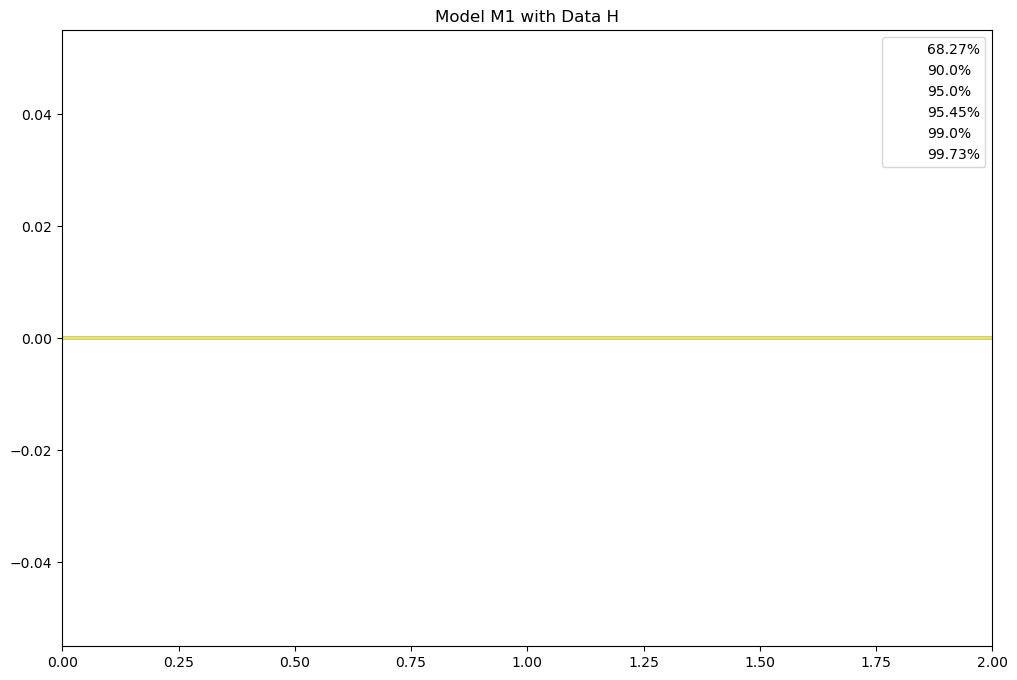

In [112]:
rng = 1
bestft = M1_bestfit
print(bestft)
lwr = 1- rng
hwr = 1 + rng
n = 100
samp1 = np.linspace(lwr*bestft[0],hwr*bestft[0],n)
samp2 = np.linspace(lwr*bestft[1],hwr*bestft[1],n)
#samp3 = np.linspace(lwr*bestft[2],hwr*bestft[2],n)
X, Y = np.meshgrid(samp1, samp2)
fig, ax = plt.subplots()
CS =  ax.contour(X,Y,chisqdata[0],levels=prob_df[2].to_list())
#print(chisqdata[0])
#print(prob_df[2].to_list())
# ax.clabel(CS,inline=True)
#ax.set_xlim([-0.1002,-0.0998])
#ax.set_ylim([1.85,2.5])
ax.set_title('Model M1 with Data H')
for i in range(len(vals)):
    CS.collections[i].set_label(str(np.round(vals[i]*100,2)) + '%')
plt.legend()